In [134]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

In [ ]:
train_folder_path = "./data/X_train/"
train_df = pd.read_csv(train_folder_path + "clinical_train.csv", sep=",")

target_df = pd.read_csv(train_folder_path + "target_train.csv", sep=",")
target_df["OS_YEARS"] = pd.to_numeric(target_df["OS_YEARS"], errors="coerce")
target_df["OS_STATUS"] = target_df["OS_STATUS"].astype(bool)


molecular_train_df = pd.read_csv(train_folder_path + "molecular_train.csv", sep=",")


## Exploration des données


In [ ]:
# train_folder_path = "./data/X_train/"
# train_df = pd.read_csv(train_folder_path + "clinical_train.csv", sep=",")
# print(train_df.count())
# target_df = pd.read_csv(train_folder_path + "target_train.csv", sep=",")
# target_df["OS_YEARS"] = pd.to_numeric(target_df["OS_YEARS"], errors="coerce")
# target_df["OS_STATUS"] = target_df["OS_STATUS"].astype(bool)
# train_df = train_df.loc[train_df['ID'].isin(target_df["ID"])]
# molecular_train_df = pd.read_csv(train_folder_path + "molecular_train.csv", sep=",")
# print(train_df.count())

ID              3323
CENTER          3323
BM_BLAST        3214
WBC             3051
ANC             3130
MONOCYTES       2722
HB              3213
PLT             3199
CYTOGENETICS    2936
dtype: int64
ID              3323
CENTER          3323
BM_BLAST        3214
WBC             3051
ANC             3130
MONOCYTES       2722
HB              3213
PLT             3199
CYTOGENETICS    2936
dtype: int64


In [82]:
train_df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [83]:
train_df.describe()

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
count,3214.000000,3051.000000,3130.000000,2722.000000,3213.000000,3199.000000
mean,5.982545,6.535164,3.264735,0.955868,9.893549,167.048900
std,7.615439,10.247219,5.237043,2.666478,2.041158,149.477031
min,0.000000,0.200000,0.000000,0.000000,4.000000,2.000000
25%,1.000000,2.700000,1.000000,0.150000,8.500000,65.500000
50%,3.000000,4.100000,2.000000,0.370000,9.700000,123.000000
75%,8.000000,6.655000,3.690000,0.783000,11.200000,229.500000
max,91.000000,154.400000,109.620000,44.200000,16.600000,1451.000000


In [84]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3323 entries, 0 to 3322
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3323 non-null   object 
 1   CENTER        3323 non-null   object 
 2   BM_BLAST      3214 non-null   float64
 3   WBC           3051 non-null   float64
 4   ANC           3130 non-null   float64
 5   MONOCYTES     2722 non-null   float64
 6   HB            3213 non-null   float64
 7   PLT           3199 non-null   float64
 8   CYTOGENETICS  2936 non-null   object 
dtypes: float64(6), object(3)
memory usage: 259.6+ KB


In [85]:
train_df.isnull().any()

ID              False
CENTER          False
BM_BLAST         True
WBC              True
ANC              True
MONOCYTES        True
HB               True
PLT              True
CYTOGENETICS     True
dtype: bool

In [86]:
train_df.loc[train_df["CYTOGENETICS"] == "46,xy"]

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
149,P117423,CCH,8.0,4.13,1.94,0.08,8.40,133.0,"46,xy"
150,P117424,CCH,18.0,4.54,1.95,0.27,13.30,102.0,"46,xy"
167,P117444,CCH,3.0,4.40,2.97,0.45,10.70,84.0,"46,xy"
169,P117446,CCH,6.0,4.27,1.78,1.17,12.10,69.0,"46,xy"
176,P117454,CCH,2.0,7.90,5.20,0.86,9.40,454.0,"46,xy"
...,...,...,...,...,...,...,...,...,...
3067,P131486,TUD,7.5,1.70,0.77,0.03,9.92,35.0,"46,xy"
3083,P131503,TUD,NaN,4.06,1.03,0.88,14.72,61.0,"46,xy"
3098,P131518,TUD,8.0,1.11,0.20,0.02,8.32,51.0,"46,xy"
3116,P131537,TUD,4.0,2.76,1.27,0.61,7.36,214.0,"46,xy"


In [87]:
target_df.describe()

,OS_YEARS
count,3173.000000
mean,2.480713
std,2.588259
min,0.000000
25%,0.652055
50%,1.652055
75%,3.572603
max,22.043836


In [88]:
target_df.loc[target_df["OS_STATUS"] == True].describe()

,OS_YEARS
count,1600.000000
mean,2.033873
std,2.061487
min,0.002740
25%,0.669863
50%,1.380822
75%,2.670548
max,17.375342


In [89]:
target_df.loc[target_df["OS_STATUS"] == False].describe()

,OS_YEARS
count,1573.000000
mean,2.935222
std,2.963922
min,0.000000
25%,0.632877
50%,2.268493
75%,4.221918
max,22.043836


In [90]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         3323 non-null   object 
 1   OS_YEARS   3173 non-null   float64
 2   OS_STATUS  3323 non-null   bool   
dtypes: bool(1), float64(1), object(1)
memory usage: 55.3+ KB


In [91]:
target_df.isnull().any()

ID           False
OS_YEARS      True
OS_STATUS    False
dtype: bool

In [92]:
target_df = target_df.dropna(subset=["OS_YEARS"])
target_df.isnull().any()

ID           False
OS_YEARS     False
OS_STATUS    False
dtype: bool

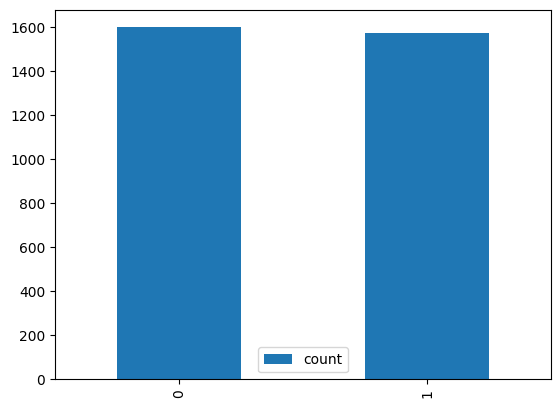

In [93]:
x = target_df["OS_STATUS"].value_counts().reset_index()
x.plot.bar()
plt.show()

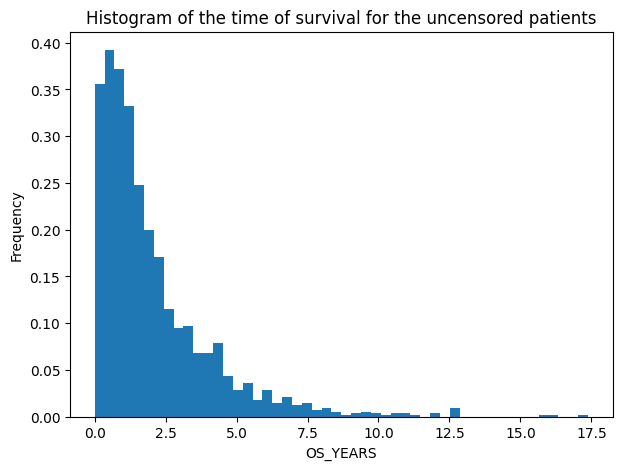

In [95]:
x = target_df.loc[target_df["OS_STATUS"] == True]["OS_YEARS"]
plt.figure(figsize=(7, 5))
plt.hist(x, bins=50, density=True)
plt.xlabel('OS_YEARS')
plt.ylabel('Frequency')
plt.title('Histogram of the time of survival for the uncensored patients')
plt.show()


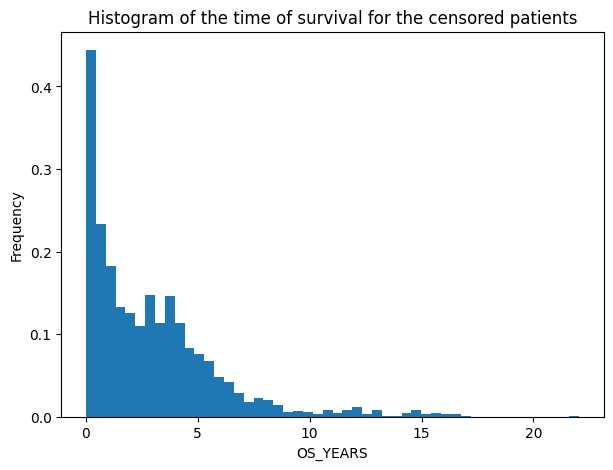

In [96]:
x = target_df.loc[target_df["OS_STATUS"] == False]["OS_YEARS"]
plt.figure(figsize=(7, 5))
plt.hist(x, bins=50, density=True)
plt.xlabel('OS_YEARS')
plt.ylabel('Frequency')
plt.title('Histogram of the time of survival for the censored patients')
plt.show()

In [100]:
nf = train_df.loc[train_df["CYTOGENETICS"] == "46,xx"]
nf_target = target_df.loc[target_df["ID"].isin(nf["ID"])]

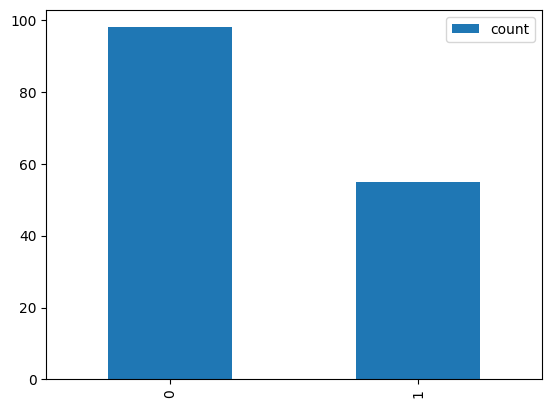

In [106]:
nf_target["OS_STATUS"].value_counts().reset_index().plot.bar()
plt.show()

In [120]:
nm = train_df.loc[train_df["CYTOGENETICS"] == "46,xy"]
nm_target = target_df.loc[target_df["ID"].isin(nf["ID"])]
nm_target = pd.concat((nm_target, nf_target)) 

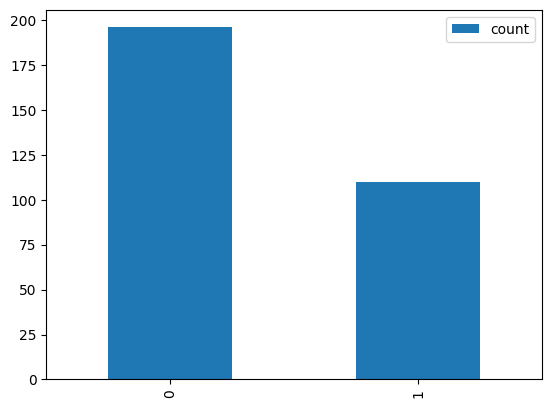

In [121]:
nm_target["OS_STATUS"].value_counts().reset_index().plot.bar()
plt.show()

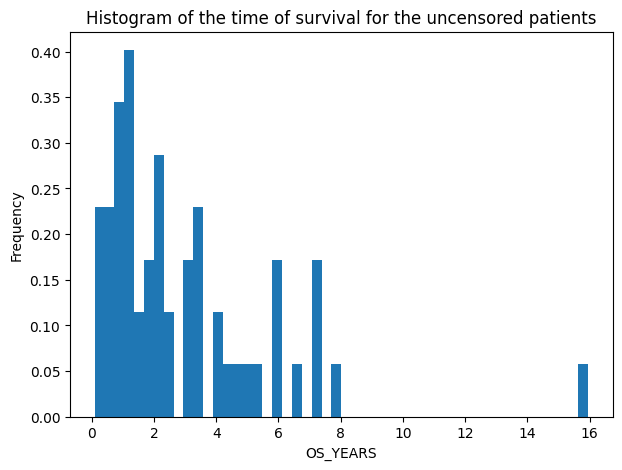

In [122]:
x = nm_target.loc[target_df["OS_STATUS"] == True]["OS_YEARS"]
plt.figure(figsize=(7, 5))
plt.hist(x, bins=50, density=True)
plt.xlabel('OS_YEARS')
plt.ylabel('Frequency')
plt.title('Histogram of the time of survival for the uncensored patients')
plt.show()


In [123]:
x.describe()

count    110.000000
mean       2.932055
std        2.773194
min        0.095890
25%        1.042466
50%        2.043836
75%        4.098630
max       15.939726
Name: OS_YEARS, dtype: float64

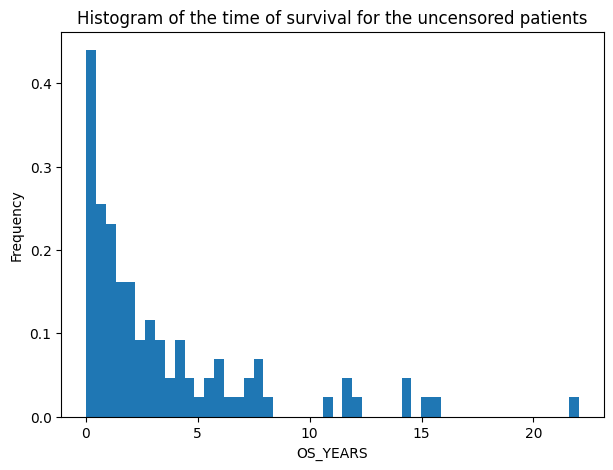

In [124]:
x = nm_target.loc[target_df["OS_STATUS"] == False]["OS_YEARS"]
plt.figure(figsize=(7, 5))
plt.hist(x, bins=50, density=True)
plt.xlabel('OS_YEARS')
plt.ylabel('Frequency')
plt.title('Histogram of the time of survival for the uncensored patients')
plt.show()

In [125]:
x.describe()

count    196.000000
mean       3.435141
std        4.171060
min        0.000000
25%        0.556164
50%        2.078082
75%        4.410959
max       22.043836
Name: OS_YEARS, dtype: float64

## Molecular

In [128]:
molecular_train_df.count()

ID                10935
CHR               10821
START             10821
END               10821
REF               10821
ALT               10821
GENE              10935
PROTEIN_CHANGE    10923
EFFECT            10935
VAF               10846
DEPTH             10821
dtype: int64

In [130]:
molecular_train_df.loc[molecular_train_df["START"] == 74732959.0]

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
116,P100164,17,74732959.0,74732962.0,G,GGGC,SRSF2,p.R94_P95insR,inframe_codon_gain,0.4954,694.0
126,P105745,17,74732959.0,74732962.0,G,GGGC,SRSF2,p.R94_P95insR,inframe_codon_gain,0.4516,1368.0
159,P120889,17,74732959.0,74732962.0,G,GGGC,SRSF2,p.R94_P95insR,inframe_codon_gain,0.6094,1966.0
220,P122305,17,74732959.0,74732962.0,G,GGGC,SRSF2,p.R94_P95insR,inframe_codon_gain,0.2778,1318.0
230,P122451,17,74732959.0,74732962.0,G,GGGC,SRSF2,p.R94_P95insR,inframe_codon_gain,0.4657,1470.0
...,...,...,...,...,...,...,...,...,...,...,...
10470,P117470,17,74732959.0,74732959.0,G,C,SRSF2,p.P95R,non_synonymous_codon,0.4150,494.0
10502,P117978,17,74732959.0,74732959.0,G,A,SRSF2,p.P95L,non_synonymous_codon,0.4820,1452.0
10509,P118014,17,74732959.0,74732959.0,G,T,SRSF2,p.P95H,non_synonymous_codon,0.4810,1446.0
10541,P120858,17,74732959.0,74732959.0,G,T,SRSF2,p.P95H,non_synonymous_codon,0.2620,933.0


In [18]:
molecular_train_df.loc[molecular_train_df["ID"] == "P132697"]

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
4736,P132697,21,44514780.0,44514780.0,C,T,U2AF1,p.R156H,non_synonymous_codon,0.3500,2620.0
10146,P132697,2,25457242.0,25457242.0,C,T,DNMT3A,p.R882H,non_synonymous_codon,0.4220,1850.0
10398,P132697,13,28602341.0,28602341.0,T,G,FLT3,p.N676T,non_synonymous_codon,0.0910,2112.0
10399,P132697,13,28608329.0,28608329.0,A,G,FLT3,p.L576P,non_synonymous_codon,0.1400,1967.0
10400,P132697,16,30747705.0,30747707.0,T,TCC,SRCAP,p.V2306fs*2,frameshift_variant,0.1477,1339.0
10401,P132697,20,31022441.0,31022442.0,A,AG,ASXL1,p.G646fs*12,frameshift_variant,0.3553,906.0
10402,P132697,21,36164904.0,36164905.0,G,GC,RUNX1,p.A324fs*276,frameshift_variant,0.3342,458.0
10403,P132697,1,36932242.0,36932242.0,G,A,CSF3R,p.Q770*,stop_gained,0.0300,2771.0
10405,P132697,4,106190822.0,106190822.0,C,T,TET2,p.P1367L,non_synonymous_codon,0.3940,1351.0


In [224]:
molecular_train_df.value_counts("CHR").reset_index()["count"]

0     1699
1     1513
2     1387
3     1204
4      999
5      866
6      596
7      537
8      369
9      365
10     326
11     192
12     155
13     128
14     116
15     115
16      91
17      55
18      42
19      41
20      18
21       4
22       3
Name: count, dtype: int64

In [254]:
chr_list = list(molecular_train_df.value_counts("CHR").reset_index()["CHR"])
new_df = train_df

In [ ]:
# for chr in chr_list:
#     name = 'Nmut'+chr
#     tmp = molecular_train_df.loc[molecular_train_df["CHR"] == chr].groupby('ID').size().reset_index(name=name)
#     new_df = new_df.merge(tmp, on="ID", how="left").fillna({name: 0})

In [255]:
new_df["IS_MUTATION"] = (new_df["CYTOGENETICS"].isin(("46,xx", "46,xy")))
new_df = new_df.drop("CYTOGENETICS", axis=1)
new_df = new_df.drop("CENTER", axis=1)


In [256]:
X = new_df.loc[new_df['ID'].isin(target_df["ID"])]
X = X.drop("ID", axis=1)
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']] = imputer.fit_transform(X_train[['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']])
X_test[['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']] = imputer.transform(X_test[['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']])

In [257]:
X_train.dtypes

BM_BLAST       float64
WBC            float64
ANC            float64
MONOCYTES      float64
HB             float64
PLT            float64
IS_MUTATION       bool
dtype: object

In [258]:
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.67
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.66


## Prediction

In [219]:
features = ["BM_BLAST", "HB", "PLT"]
X = train_df.loc[train_df['ID'].isin(target_df["ID"]), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

In [138]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [139]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'PLT']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB', 'PLT']])
X_test[['BM_BLAST', 'HB', 'PLT']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'PLT']])

In [148]:
# Import necessary libraries
import lightgbm as lgb
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# Define LightGBM parameters
lgbm_params = {
    'max_depth': 3,
    'learning_rate': 0.05,
    'verbose': -1
}

# Prepare the data for LightGBM
# Scale the target (OS_YEARS) to reduce skew, apply weights based on event status
X_train_lgb = X_train  # Features for training
y_train_transformed = y_train['OS_YEARS']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Make predictions on the training and testing sets
pred_train = -model.predict(X_train)
pred_test = -model.predict(X_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")

LightGBM Survival Model Concordance Index IPCW on train: 0.69
LightGBM Survival Model Concordance Index IPCW on test: 0.65


<Figure size 2000x1000 with 0 Axes>

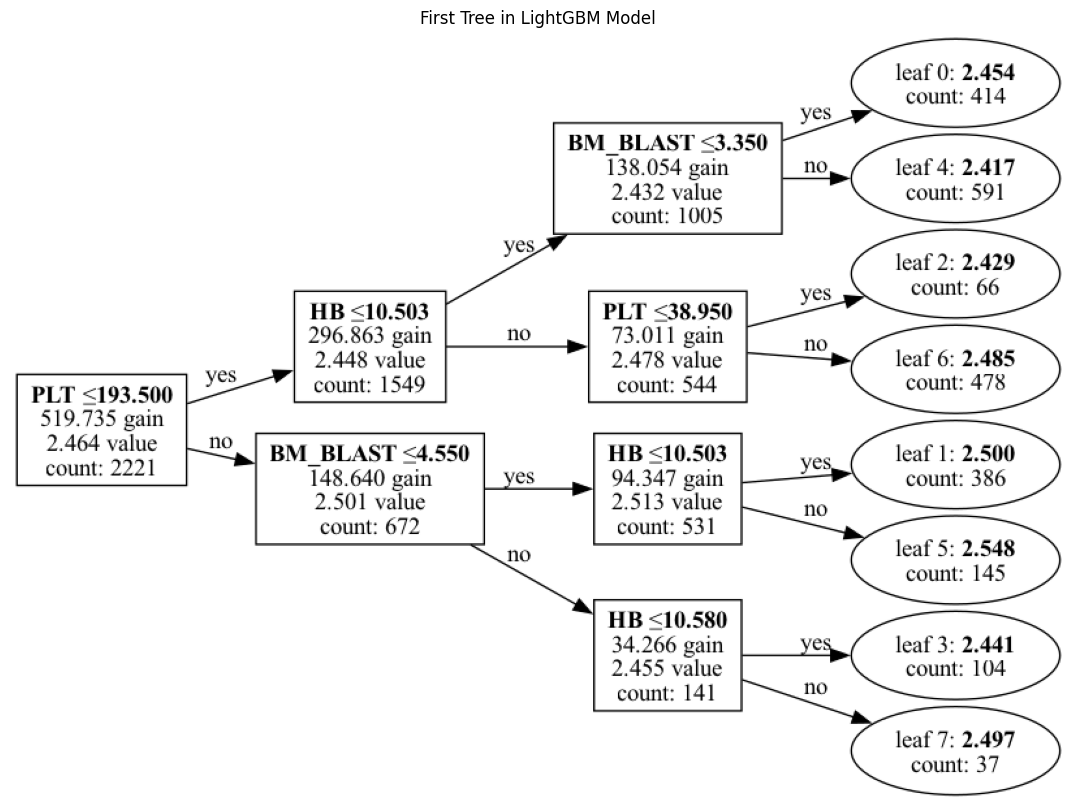

In [141]:
# Assuming the LightGBM model is defined as `model`
plt.figure(figsize=(20, 10))
lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.title("First Tree in LightGBM Model")
plt.show()

In [149]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.66
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.66


In [200]:
# Step: Extract the number of somatic mutations per patient
# Group by 'ID' and count the number of mutations (rows) per patient
tmp = molecular_train_df.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_2 = train_df.merge(tmp, on='ID', how='left').fillna({'Nmut': 0})

In [155]:
# Select features
features = ['BM_BLAST', 'HB', 'PLT', 'ANC', 'MONOCYTES', 'Nmut']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df_2.loc[df_2['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

In [156]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [163]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'PLT', 'ANC', 'MONOCYTES', 'Nmut']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB', 'PLT', 'ANC', 'MONOCYTES', 'Nmut']])
X_test[['BM_BLAST', 'HB', 'PLT', 'ANC', 'MONOCYTES', 'Nmut']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'PLT', 'ANC', 'MONOCYTES', 'Nmut']])

In [164]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.69
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.68
